# Sexism Classification with LLMs and Prompting Engineering
In this notebook, our aim is to evaluate the performance of the LLMs on the sexism classification problem by prompting the models in two ways:
- Simple Prompts
    - These prompts passes our tweets to the model to classify
- Few-Shot Prompts
    - These prompts passes our tweets along with examples to the model to classify

We will use two dataset:
- Test Dataset: This dataset containts tweets and their corresponding labels
- Demonstraionts Dataset: This dataset provides examples that we can use them to show the models how to work




## Outlines
1. [Packages](#packages)
2. [Connecting to Hugging Face](#huggapi)
3. [Data Importing](#Data-Importing)
4. [Modularization](#modularization)
    - [Prompts Settings](#prompts-settings)
    - [Function](#functions)
5. [Model Setup](#model-setup)
    - [Mistral V2](#mistral-v2)
        - [Model Settings](#mistral-v2-model)
        - [Inference](#mistral-v2-inference)
        - [Few Shot Inference](#mistral-v2-few-shot)
    - [Mistral V3](#mistral-v3)
        - [Model Settings](#mistral-v3-model)
        - [Inference](#mistral-v3-inference)
        - [Few Shot Inference](#mistral-v3-few-shot)
6. [Metrics](#metrics)
7. [Results Analysis](#error-analysis)

<a name='packages'></a>
# Packages
This sections will import and install all the necessary libraries for this project.

In [ ]:
# Optional
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
%pip install transformers
%pip install datasets
%pip install accelerate -U
%pip install evaluate
%pip install bitsandbytes

In [ ]:
from transformers import pipeline, AutoModelForCausalLM, AutoTokenizer
from transformers.utils.quantization_config import BitsAndBytesConfig
from transformers import DataCollatorWithPadding
from transformers import BitsAndBytesConfig

from sklearn.metrics import accuracy_score, f1_score
from datasets import Dataset
import evaluate

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import requests
import os
import re

import torch
from torch.utils.data import DataLoader

torch.cuda.is_available()

True

<a name='huggapi'></a>
# Hugging Face Setup
Establish your connection to the Hugging Face.
- Create an account at [Hugging Face](https://huggingface.co/)
- From model card page accept the community license
- From settings create an api token key
- Change the token in the following

In [ ]:
!huggingface-cli login --token <YOUR_TOKEN>

<a name='Data-Importing'></a>
# Data Importing
Datasets are provided in the github. Following cells will:
- Define a function to download the datasets
- Imports the downloaded datasets as a dataframe to the notebooks



> If you already have local path to the files, you can skip next two cells and update the paths to files on the third cell.

In [ ]:
def download_file(url, filename):
    """Downloads a file from a URL to the specified filename."""
    try:
        response = requests.get(url, stream=True)

        # Raise an exception for bad status codes (e.g., 404)
        response.raise_for_status()

        # Saving the file
        with open(filename, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                file.write(chunk)
        print(f"File '{filename}' downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")

a2_test_url = "https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/main/2024-2025/Assignment%202/data/a2_test.csv"
a2_file_name = "a2_test.csv"

demonstrations_url = "https://github.com/nlp-unibo/nlp-course-material/blob/main/2024-2025/Assignment%202/data/demonstrations.csv"
demon_file_name = "demonstrations.csv"

In [ ]:
# %%capture
# Run this cell to download the datasets from the
# specified repository in the previous cell, if you have the data, jump to next
# download_file(a2_test_url, a2_file_name)
# download_file(demonstrations_url, demon_file_name)

In [ ]:
# Update the following two paths base on your environment

path_to_a2 = "/content/drive/MyDrive/Colab Notebooks/Sexism Detection/Datasets/a2_test.csv"
df_test = pd.read_csv(path_to_a2)

path_to_demonstrations = "/content/drive/MyDrive/Colab Notebooks/Sexism Detection/Datasets/demonstrations.csv"
df_demonst = pd.read_csv(path_to_demonstrations)

In [ ]:
df_test['label_sexist_int'] = df_test['label_sexist'].apply(lambda x: 1 if x == 'sexist' else 0)

<a name='modularization'></a>
# Modularization
In this part we will define functions, and variables to use them later in this project. Since, most of the functions are the same, we will try to gather these common variables in one place and use them later by calling them, to avoid redundancy.


<a name='prompts-settings'></a>
## Prompts Settings
The following two cells define two different templates for the prompts that we want to use.
- Simple prompt
    - This is the prompt which is used to pass only the test tweets to the models for the task of classification
- Few Shot prompt
    - This prompt is similar to the first prompt in terms of defining tasks for the model. However, this prompt will be used to also provide some examples for the model.

In [ ]:
simple_prompt = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        TEXT:
        {text}

        ANSWER:
        """
    }
]

In [ ]:
prompt_few_shot = [
    {
        'role': 'system',
        'content': 'You are an annotator for sexism detection.'
    },
    {
        'role': 'user',
        'content': """Your task is to classify input text as containing sexism or not. Respond only YES or NO.

        EXAMPLES:
        {examples}

        TEXT:
        {text}

        ANSWER:
        """
    }
]

The following two cells contain two functions:
- **Prepare prompts**<br>
    This function takes a list of raw text derived from the test dataset from the input along with the prompt templates. It formats the templates and replaces the placeholder `{text}` with these tweets. <br>
    Additionaly, if demonstrations is not None, it replaces the placeholder `{examples}` with some of examples in the prompts as well.
- **Choose Demonstrations**<br>
    This function is responsible for choosing the examples that we want to integrate to the prompts and pass it to the models.
    

In [ ]:
def prepare_prompts(texts, prompt_template, tokenizer, demonstrations):
    """
    This function format input text samples into instructions prompts.

    Inputs:
        texts: input texts to classify via prompting
        prompt_template: the prompt template provided in this assignment
        tokenizer: the transformers Tokenizer object instance associated with the chosen model card

    Outputs:
        input texts to classify in the form of instruction prompts
    """
    prompt = tokenizer.apply_chat_template(prompt_template, tokenize=False, add_generation_prompt=True)

    if demonstrations == None:
        ready_prompts = []
        for txt in texts:
            prompt_formatted = prompt.format(text=txt)
            ready_prompts.append(prompt_formatted)
        return ready_prompts
    else:
        ready_prompts = []
        for txt in texts:
            prompt_formatted = prompt.format(text=txt, examples=demonstrations)
            ready_prompts.append(prompt_formatted)
        return ready_prompts


In [ ]:
def build_few_shot_demonstrations(demonstrations, num_per_class=1):
    """
    Inputs:
        demonstrations: the pandas.DataFrame object wrapping demonstrations.csv
        num_per_class: number of demonstrations per class

    Outputs:
        a list of textual demonstrations to inject into the prompt template.
    """
    positive_examples = demonstrations[demonstrations['label_sexist'] == 'sexist'].sample(n=num_per_class, random_state=42)
    negative_examples = demonstrations[demonstrations['label_sexist'] == 'not sexist'].sample(n=num_per_class, random_state=42)

    few_shot_examples = []
    for _, row in positive_examples.iterrows():
        few_shot_examples.append(f"TEXT: {row['text']}\nANSWER: YES")
    for _, row in negative_examples.iterrows():
        few_shot_examples.append(f"TEXT: {row['text']}\nANSWER: NO")

    return "\n".join(few_shot_examples)


<a name='functions'></a>
## Functions
This section modularizes the repeated codes to avoid repeatitions. In a bigger scale, the following couple of cells can be divided by two:
- First couple of cells are responsible for the text processing
    - Creating the Data Loader
        - Text preparation
        - Collateing text
    - Processing the Generated Reponse
        - Extracting the answer from the response
        - Converting the answer to numerical response
- The last cell is reponsible for inferencing
    - Takes data and prompts from the input
    - Generates response which need to be pass to the processing reponse function



The next three functions together creates the following pipeline:
- First, the given `test dataset` is converted to a `Dataset` object.
- Then, each tweet in this `Dataset` is fed to the prepare prompts and prepare prompts returns the corresponding prepared prompts for that tweet.
- After that, from this dataset we choose two columns, one is the column of prepared prompts, created in the previous step, and the other column is the label column.
- Finally, we append the collate function to the `DataLoader`. In other words, through what we defined in the collate, the function encodes the prepared text, applies the possible paddings and truncations and changes these inputs to numerical understandable values for the model.

In [ ]:
def texts_preparation(example):
    example['text_prepared'] = prepare_prompts([example['text']], prompt, tokenizer, demonstrations)[0]
    return example

def collate_fn(batch):
    texts = tokenizer.batch_encode_plus([it['text_prepared'] for it in batch], return_tensors='pt', padding=True, truncation=False)
    labels = torch.tensor([it['label_sexist_int'] for it in batch])

    return texts, labels

def create_data_loader(df_test):
    test_data = Dataset.from_pandas(df_test)
    test_data = test_data.map(texts_preparation)
    test_data = test_data.select_columns(['text_prepared', 'label_sexist_int'])
    data_loader = DataLoader(test_data,
                            batch_size=1,
                            shuffle=False,
                            collate_fn=collate_fn)
    return test_data, data_loader

Following two functions are reponsible for extracting the `Answer` from the generated output of the model. Together, they recognize, and convert the reponse to the numberical vaules.

Addtionaly, the `convert response functino` is also reponsible for modifying a given dictionary. This dictionary is used at the end of the notebook to calculate the `Fail/Ratio` metrics, which will be dicussed later in this notebook.

In [ ]:
def extract_response(response):
    match = [m for m in re.finditer('ANSWER:', response)][-1]
    parsed = response[match.end():].strip()
    return parsed

def convert_response(response, dict_of_responses_count):
    if re.search(r"\bYES\b", response, re.IGNORECASE):
        dict_of_responses_count["YES"] += 1
        return 1, dict_of_responses_count
    elif re.search(r"\bNO\b", response, re.IGNORECASE):
        dict_of_responses_count["NO"] += 1
        return 0, dict_of_responses_count
    else:
        dict_of_responses_count["WRONG"] += 1
        return 0, dict_of_responses_count

The following function is responsible for taking in the generated response of the model and create the predictions and counting dictionary with the help of two previous functions.

In [ ]:
def process_response(text_responses):
    """
    This function takes a textual response generated by the LLM
    and processes it to map the response to a binary label.

    Inputs:
        response: generated response from LLM

    Outputs:
        parsed binary response: return 1 if YES and 0 if NO
    """
    dict_of_responses_count = {"YES": 0, "NO": 0, "WRONG": 0}
    responses = []
    predictions = []
    raw_response = [extract_response(text) for text in text_responses]
    responses.extend(raw_response)

    batch_predictions = []
    for response in responses:
        converted_response = convert_response(response, dict_of_responses_count)
        batch_predictions.append(converted_response[0])
        dict_of_responses_count = converted_response[1]
    predictions.extend(batch_predictions)

    return predictions, dict_of_responses_count

`Generate Reponse` function is tasked to inference the input and generate a reponse. The input of this function is the created `DataLoader` and the output of this function is what we send to the `process responses`.

The `generation_config` variable will be defined later on each model's section. It is the defined configuration of that specific model.

In [ ]:
def generate_responses(model, prompt_examples):
    """
    This function implements the inference loop for a LLM model.
    Given a set of examples, the model is tasked to generate a response.

    Inputs:
        model: LLM model instance for prompting
        prompt_examples: pre-processed text samples

    Outputs:
        generated responses
    """
    raw_responses = []
    with torch.inference_mode():
        for batch_x, batch_y in tqdm(data_loader, desc="Generating responses"):
            response = model.generate(
                input_ids=batch_x['input_ids'].to(model.device),
                attention_mask=batch_x['attention_mask'].to(model.device),
                generation_config=generation_config,
                do_sample=False,
                use_cache=True
            )
            raw_response = tokenizer.batch_decode(response, skip_special_tokens=True)
            raw_responses.extend(raw_response)
    return raw_responses

<a name='model-setup'></a>
# Model setup
In this section, using the Hugging Face API, we will initialize some LLMs and do their corresponding configurations and then inference.

Following cell defines the model ID that we want to use. In this notebook we are using the Mistral 7B Instruct V2 and V3 models.

In [ ]:
mistral2_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
mistral3_model_id = "mistralai/Mistral-7B-Instruct-v0.3"

models_results = {}

<a name='mistral-v2'></a>
## Mistral V2
According to [Hugging Face](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.2), the `Mistral-7B-Instruct-v0.2` Large Language Model (LLM) is an instruct fine-tuned version of the `Mistral-7B-v0.2`. `Mistral-7B-v0.2` has the following changes compared to `Mistral-7B-v0.1`
- 32k context window (vs 8k context in v0.1)
- Rope-theta = 1e6
- No Sliding-Window Attention



<a name='mistral-v2-model'></a>
### Model Settings
In the next cell, the model and tokenizer are imported through their dedicated command. Then, a quantization is applied and some other settings like special token settings, number of token generating are also applied to the model.

In [ ]:
# Load the tokenizer and model with quantization
tokenizer_mistral2 = AutoTokenizer.from_pretrained(mistral2_model_id)
tokenizer_mistral2.pad_token = tokenizer_mistral2.eos_token

terminators = [
    tokenizer_mistral2.eos_token_id,
    tokenizer_mistral2.convert_tokens_to_ids("<|eot_id|>")
]

# Quantization config; Mistral V2 model; Using 4-bit quantization.
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_mistral2 = AutoModelForCausalLM.from_pretrained(
    mistral2_model_id,
    quantization_config=bnb_config,
    device_map="auto"
    )

generation_config_mistral2 = model_mistral2.generation_config
generation_config_mistral2.max_new_tokens = 10
generation_config_mistral2.eos_token_id = tokenizer_mistral2.eos_token_id
generation_config_mistral2.pad_token_id = tokenizer_mistral2.eos_token_id
generation_config_mistral2.temperature = None
generation_config_mistral2.num_return_sequences = 1

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

<a name='mistral-v2-inference'></a>
### Inference
We are now ready to define the inference loop where we prompt the model with each pre-processed sample. Essentially, we are setting the variables, which will be used in the functions that we're calling, to the correct values respecting the current model and inference settings that we want to work on.

Next cell is reponsible for classifying the tweets in the test set. Here we are only applying a simple inference without providing any example to the model. In other words, we are applying zero-shot prompting to the model. The generated outputs, responses, and classifications are saved and will be discussed later in this notebook.

In [ ]:
# Setting Parameters
tokenizer = tokenizer_mistral2
model = model_mistral2
generation_config = generation_config_mistral2
prompt = simple_prompt
demonstrations = None

# Generating Data Loader Instance on the Set Parameters
test_data, data_loader = create_data_loader(df_test)
responses = generate_responses(model, "prompt_examples_tokenized")
predictions, dict_of_responses_count = process_response(responses)

models_results['mistral2_inference'] = [responses, predictions, dict_of_responses_count]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Generating responses: 100%|██████████| 300/300 [03:26<00:00,  1.45it/s]


<a name='mistral-v2-few-shot'></a>
### Few Shot Inference
So far, we have tested models in a zero-shot fashion: we provide the input text to classify and instruct the model to generate a response. We are now interested in performing few-shot prompting to see the impact of providing demonstration examples.

To do so, we slightly change the variables as follow and call the inference method again on these new instantiatiopn of the variables.

In [ ]:
for few in [2, 3, 4]:
    # Setting Parameters
    tokenizer = tokenizer_mistral2
    model = model_mistral2
    generation_config = generation_config_mistral2
    prompt = prompt_few_shot
    demonstrations = build_few_shot_demonstrations(df_demonst, num_per_class=few)

    # Generating Data Loader Instance on the Set Parameters
    test_data, data_loader = create_data_loader(df_test)
    responses = generate_responses(model, "prompt_examples_tokenized")
    predictions, dict_of_responses_count = process_response(responses)

    models_results[f'mistral2_{few}_shot_inference'] = [responses, predictions, dict_of_responses_count]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Generating responses: 100%|██████████| 300/300 [03:31<00:00,  1.42it/s]


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Generating responses: 100%|██████████| 300/300 [03:28<00:00,  1.44it/s]


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Generating responses: 100%|██████████| 300/300 [03:30<00:00,  1.43it/s]


<a name='mistral-v3'></a>
## Mistral V3

According to [Hugging Face](https://huggingface.co/mistralai/Mistral-7B-Instruct-v0.3), the `Mistral-7B-Instruct-v0.3` Large Language Model  is an instruct fine-tuned version of the `Mistral-7B-v0.3`. `Mistral-7B-v0.3` has the following changes compared to `Mistral-7B-v0.2`
- Extended vocabulary to 32768
- Supports v3 Tokenizer
- Supports function calling

<a name='mistral-v3-model'></a>
### Model Settings
In the next cell, the model and tokenizer are imported through their dedicated command. Then, a quantization is applied and some other settings like special token settings, number of token generating are also applied to the model. This is very similar to what we did for the version 2 previously.

In [ ]:
# Load the tokenizer and model with quantization
tokenizer_mistral3 = AutoTokenizer.from_pretrained(mistral3_model_id)
tokenizer_mistral3.pad_token = tokenizer_mistral3.eos_token

terminators = [
    tokenizer_mistral3.eos_token_id,
    tokenizer_mistral3.convert_tokens_to_ids("<|eot_id|>")
]

# Quantization config; Mistral V2 model; Using 4-bit quantization.
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model_mistral3 = AutoModelForCausalLM.from_pretrained(
    mistral3_model_id,
    quantization_config=bnb_config,
    device_map="auto")

generation_config_mistral3 = model_mistral3.generation_config
generation_config_mistral3.max_new_tokens = 10
generation_config_mistral3.eos_token_id = tokenizer_mistral3.eos_token_id
generation_config_mistral3.pad_token_id = tokenizer_mistral3.eos_token_id
generation_config_mistral3.temperature = None
generation_config_mistral3.num_return_sequences = 1

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

<a name='mistral-v3-inference'></a>
### Inference
We are now ready to define the inference loop where we prompt the model with each pre-processed sample. Essentially, we are setting the variables, which will be used in the functions that we're calling, to the correct values respecting the current model and inference settings that we want to work on.

Next cell is reponsible for classifying the tweets in the test set. Here we are only applying a simple inference without providing any example to the model. In other words, we are applying zero-shot prompting to the model. The generated outputs, responses, and classifications are saved and will be discussed later in this notebook.

In [ ]:
# Setting Parameters
tokenizer = tokenizer_mistral3
model = model_mistral3
generation_config = generation_config_mistral3
prompt = simple_prompt
demonstrations = None

# Generating Data Loader Instance on the Set Parameters
test_data, data_loader = create_data_loader(df_test)
responses = generate_responses(model, "prompt_examples_tokenized")
predictions, dict_of_responses_count = process_response(responses)

models_results['mistral3_inference'] = [responses, predictions, dict_of_responses_count]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Generating responses: 100%|██████████| 300/300 [01:08<00:00,  4.37it/s]


<a name='mistral-v3-few-shot'></a>
### Few Shot Inference
So far, we have tested models in a zero-shot fashion: we provide the input text to classify and instruct the model to generate a response. We are now interested in performing few-shot prompting to see the impact of providing demonstration examples.

To do so, we slightly change the variables as follow and call the inference method again on these new instantiatiopn of the variables.

In [ ]:
for few in [2, 3, 4]:
    # Setting Parameters
    tokenizer = tokenizer_mistral3
    model = model_mistral3
    generation_config = generation_config_mistral3
    prompt = prompt_few_shot
    demonstrations = build_few_shot_demonstrations(df_demonst, num_per_class=few)

    # Generating Data Loader Instance on the Set Parameters
    test_data, data_loader = create_data_loader(df_test)
    responses = generate_responses(model, "prompt_examples_tokenized")
    predictions, dict_of_responses_count = process_response(responses)

    models_results[f'mistral3_{few}_shot_inference'] = [responses, predictions, dict_of_responses_count]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Generating responses: 100%|██████████| 300/300 [01:23<00:00,  3.58it/s]


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Generating responses: 100%|██████████| 300/300 [01:27<00:00,  3.44it/s]


Map:   0%|          | 0/300 [00:00<?, ? examples/s]

Generating responses: 100%|██████████| 300/300 [01:31<00:00,  3.29it/s]


<a name='metrics'></a>
# Metrics

In order to evaluate selected LLMs, we need to compute performance metrics. In particular, we are interested in computing **accuracy** since the provided data is balanced with respect to classification classes. As well as the F1 score and the fail-ratio.

The fail-ratio is defined as $W / T$, where `W` corresponds to number of wrong response that is the number of time we didn't get the exact reponse from the model. The exact response is 'YES' or 'NO'. There can be some other words after these two since we are defining the number of tokens that model can generate. But, what matters is to have the exact answer 'YES' or 'NO' immediately in the starting of the generation, as we defined this to the model exactly.

In [ ]:
acc_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')

def compute_metrics(responses, y_true):
    """
    This function takes predicted and ground-truth labels and compute metrics.
    In particular, this function compute accuracy and fail-ratio metrics.
    This function internally invokes `process_response` to compute metrics.

    Inputs:
        responses: generated LLM responses
        y_true: ground-truth binary labels

    Outputs:
        dictionary containing desired metrics
    """
    f1 = f1_metric.compute(predictions=responses, references=y_true, average='macro')
    acc = acc_metric.compute(predictions=responses, references=y_true)
    fail_ratio = f"{dict_of_responses_count['WRONG']} / {len(y_true)} = {dict_of_responses_count['WRONG'] / 300}"
    return {**f1, **acc}, fail_ratio

<a name='error-analysis'></a>
# Results Analysis
Next couple of cells, studies the performance of the models and generated outputs.

In [ ]:
ground_truth = np.array(test_data['label_sexist_int'])

for model in models_results.keys():
    print("## ---------------------------------------- ##")
    print(f"Reporting the metrics for model: {model}")
    results = models_results[model]
    responses, predictions, dict_of_responses_count = tuple(results)

    predictions = np.array(predictions)
    metric, fail_rate = compute_metrics(predictions, ground_truth)
    print(f"Accuracy: {metric['accuracy']}")
    print(f"F1 Score: {metric['f1']}")
    print(f"Fail Ratio: {fail_rate}")
    print("## ---------------------------------------- ##\n\n")


## ---------------------------------------- ##
Reporting the metrics for model: mistral2_inference
Accuracy: 0.7466666666666667
F1 Score: 0.742965367965368
Fail Ratio: 30 / 300 = 0.1
## ---------------------------------------- ##


## ---------------------------------------- ##
Reporting the metrics for model: mistral2_2_shot_inference
Accuracy: 0.6733333333333333
F1 Score: 0.6695738176586945
Fail Ratio: 2 / 300 = 0.006666666666666667
## ---------------------------------------- ##


## ---------------------------------------- ##
Reporting the metrics for model: mistral2_3_shot_inference
Accuracy: 0.6666666666666666
F1 Score: 0.6648643817864963
Fail Ratio: 0 / 300 = 0.0
## ---------------------------------------- ##


## ---------------------------------------- ##
Reporting the metrics for model: mistral2_4_shot_inference
Accuracy: 0.64
F1 Score: 0.637275536250056
Fail Ratio: 2 / 300 = 0.006666666666666667
## ---------------------------------------- ##


## -----------------------------

These results show that the mistral 2 from the Accuracy and F1-Score point of view is the best model. However, this model for 30 times couldn't generate the exact response we asked it to generate which is the largest fail ratio between all the combinatinos and models. On the other side, the mistral 3 with provided 2, 3, 4 shots is performing as perfect as mistral 2, but with no fail generation. This suggests that the mistral 3 has a better understanding of the input.

Moreover, prompting with providing examples to the mistral 2 only showed a better response generation and we are experiencing 2 to 0 failures in generating with the correct format.

When we provided more examples for the mistral 3, it showed an improvement in almost all the metrics, unlike the mistral v2.

In the next we'll look at the confusion matrices.

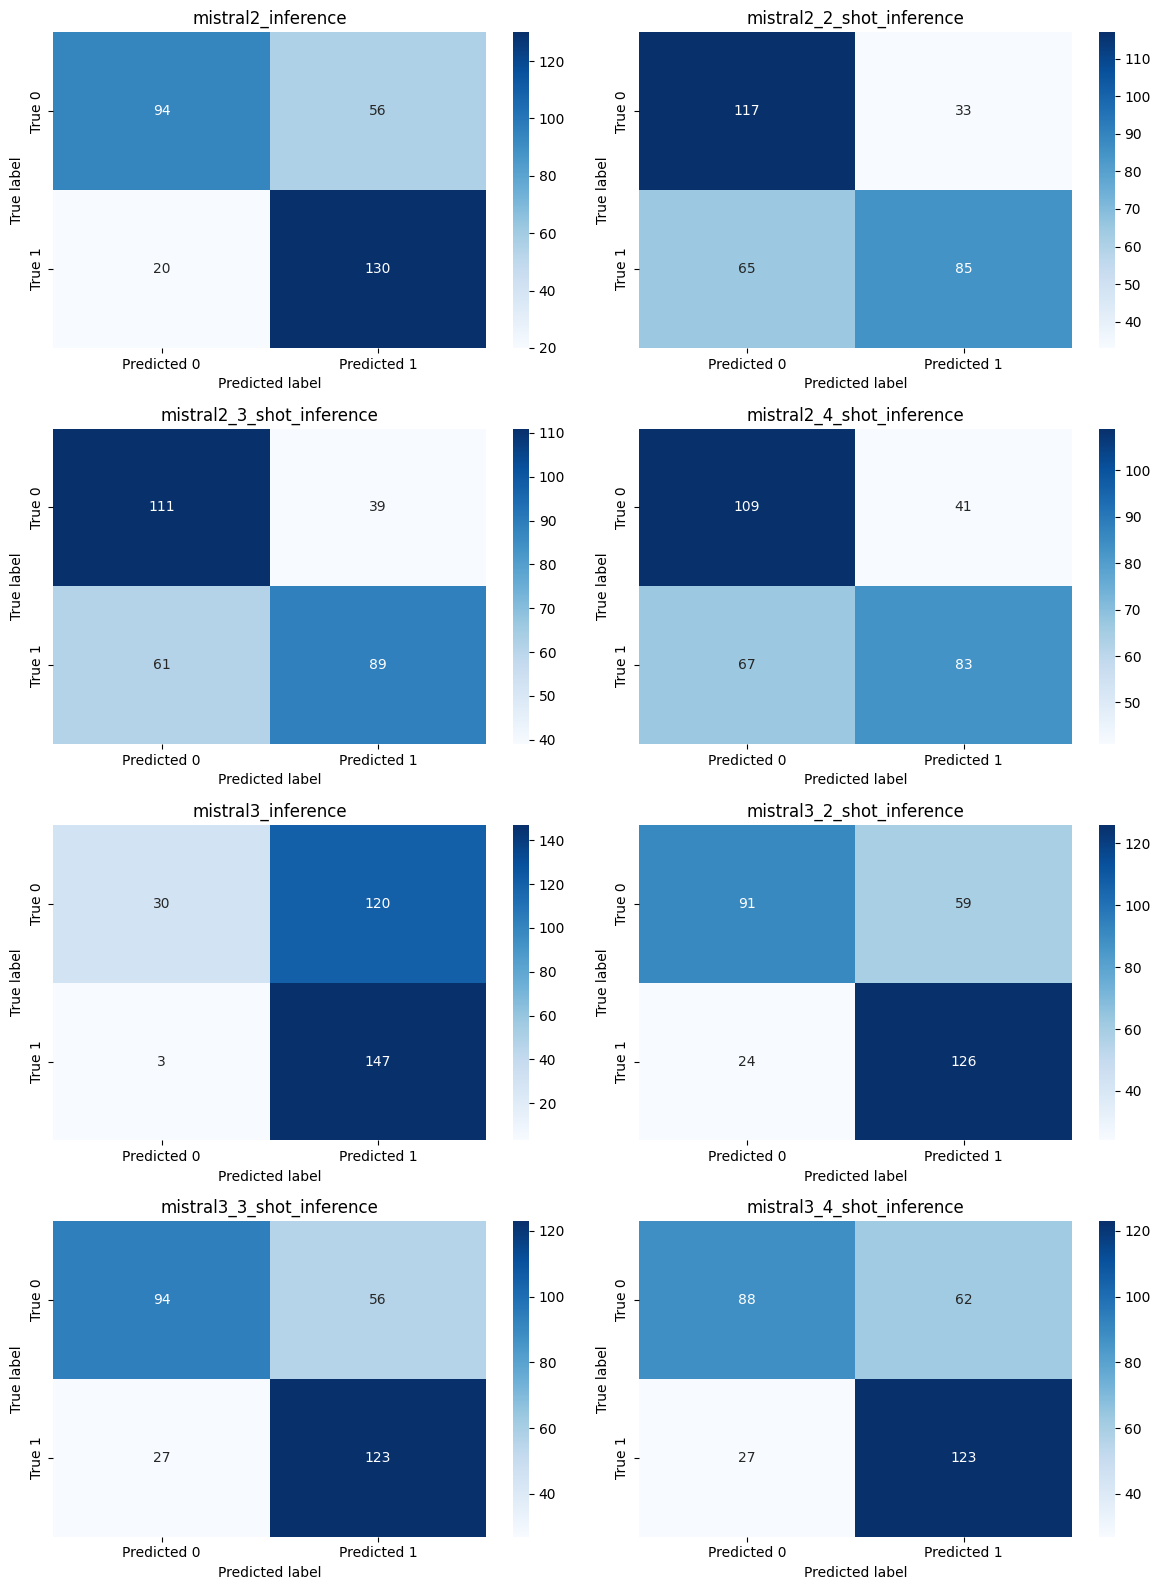

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(12, 16))
axes = axes.ravel()

for idx, model in enumerate(models_results.keys()):
    results = models_results[model]
    responses, predictions, dict_of_responses_count = tuple(results)

    cm = confusion_matrix(ground_truth, predictions)

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',
                xticklabels=["Predicted 0", "Predicted 1"],
                yticklabels=["True 0", "True 1"],
                ax=axes[idx])

    axes[idx].set_title(f"{model}")
    axes[idx].set_ylabel("True label")
    axes[idx].set_xlabel("Predicted label")

plt.tight_layout()
plt.show()

Diagrams on mistral 2 are showing a significant changes on the predictions of the right class as we provided the more examples for the model. The simple inference model is the best model on predicting the class 1 and is the worst class in predicting the class 0. Interestingly, a pattern of more wrong prediction is happening by providing examples to the models. The model shows more desire for predicting the class 0 as we provided the examples for it. The examples are being provided carefully and there is not bias in them. For mistral 2, the model, in all the three examples of few-shot, is trying to predict ~170 instances as class 0 and ~120 as class 1.

The diagrams for mistral 3 is also showing a same attitudes. The base inference model is predicting most of the tweets as the class 1, almost half which is wrong(120 wrong prediction). This although the number of correct prediction for the class 1 in this model is cosiderable, however, the wrong prediction has also good probabilty here, making this model the worst model. As we have provided examples for the model, its performance got better on predicting the correct class and we are experienceing a more balance of prediction in the model. This suggests that, we can change the attitues of LLMs by providing examples for them.

